In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd 'drive/My Drive/Siamese/Speaker/Time'

/content/drive/My Drive/Siamese/Speaker/Time


In [3]:
import sys
sys.path.insert(0, '..')
sys.path.insert(0, '../../Data')
sys.path.insert(0, '../../Encoder/Time')
sys.path.insert(0, '../../Encoder/Freq')
sys.path.insert(0, '../../Encoder')
sys.path.insert(0, '../../Conference')
sys.path.insert(0, '../../Place')

In [4]:
!pip install torchvision==0.5.0
!pip install torchaudio==0.4.0

     |████████████████████████████████| 4.0MB 8.3MB/s 
     |████████████████████████████████| 753.4MB 23kB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101
     |████████████████████████████████| 3.1MB 9.4MB/s 


In [5]:
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [6]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

In [7]:
DATASET_PATH = '/content/drive/My Drive/DataSet'
EPOCH_NUM = 10
SPEAKERS_NUM = 20

torch.backends.cudnn.deterministic = True

NUM_WORKERS = 4

In [8]:
from IdentificationDataset import IdentificationDataset
from IdentificationDataset import ReturnType

from torchvision.transforms import Compose
from Normalize import Normalize
from ToTensor import ToTensor

DATASET_PATH = '/content/drive/My Drive/DataSet'

transforms = Compose([
    Normalize(),
    ToTensor()
])

testset = IdentificationDataset(DATASET_PATH, 
                                SPEAKERS_NUM,
                                train=False, 
                                transform=transforms,
                                lenght=3,
                                return_type=ReturnType.STANDARD)
testsetloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=1, 
                                            num_workers=NUM_WORKERS)

print("lenght test loader ", len(testsetloader))


sample lenght  3
lenght test loader  2134


In [9]:
from Conference import Conference

# Define default device, we should use the GPU (cuda) if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
net = Conference(DEVICE,
                 avg=False,
                 time=True)

net.load_encoder(size=1)
net.to(DEVICE)

cuda
Encoder loaded


Conference(
  (encoder): Time(
    (block0): Conv1DBlock(
      (conv): Conv1d(1, 16, kernel_size=(9,), stride=(2,))
      (acti): ReLU()
      (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool1d(kernel_size=9, stride=8, padding=0, dilation=1, ceil_mode=False)
    )
    (block1): Conv1DBlock(
      (conv): Conv1d(16, 128, kernel_size=(9,), stride=(2,))
      (acti): ReLU()
      (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool1d(kernel_size=9, stride=4, padding=0, dilation=1, ceil_mode=False)
    )
    (block2): Conv1DBlock(
      (conv): Conv1d(128, 256, kernel_size=(9,), stride=(2,))
      (acti): ReLU()
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool1d(kernel_size=9, stride=4, padding=0, dilation=1, ceil_mode=False)
    )
    (block3): Conv1DBlock(
      (conv1): Conv1d(256, 64, kernel_size=(

In [10]:
with torch.no_grad():
  # test
  net.eval()
  # Store the speakers
  speakers_list = testset.get_speakers_list(20)
  net.initspeakers(speakers_list)  
  net.initplaces(speakers_list)

In [11]:
import numpy as np

dict_error = {}
dict_nb = {}
conf_gold_label = None
conf_pred_label = None

with torch.no_grad():
  best_accuracy = 0
  mean_accuracies = []
  topk_accuracies = []
  min_accuracies = []

  for epoch_num in range(EPOCH_NUM):
    print("*** Epoch ", epoch_num, " ***")
    mean_accuracy = 0
    topk_accuracy = 0
    min_accuracy = 0
    nb_test = 0
    if epoch_num == EPOCH_NUM-1:
      print("activate stats")
      net.activatestats()
      # Confusion matrix
      conf_gold_label = []
      conf_pred_label = []

    for speaker in speakers_list:
      id = speaker[0]
      dict_error[id] = 0
      dict_nb[id] = 0

    for iter_num, (gold_label, sample) in tqdm(enumerate(testsetloader)):
      mean_label, topk_label, min_label = net(sample, gold_label)
      if conf_gold_label != None:
        conf_gold_label.append(gold_label)
      if conf_pred_label != None:
        conf_pred_label.append(min_label)      
      nb_test += 1
      gold_label = gold_label.item()
      dict_nb[gold_label] += 1

      if gold_label == mean_label:
        mean_accuracy += 1
      if gold_label == topk_label:
        topk_accuracy += 1
      else:
        dict_error[gold_label] += 1
      if gold_label == min_label:
        min_accuracy += 1

    mean_accuracy /= nb_test
    topk_accuracy /= nb_test
    min_accuracy /= nb_test
    mean_accuracies.append(mean_accuracy)
    topk_accuracies.append(topk_accuracy)
    min_accuracies.append(min_accuracy)
    print("accuracy mean ", mean_accuracy, "topk", topk_accuracy, 
          " min ", min_accuracy)
    add = 0
    nb = 0
    for id in dict_error:
      add += dict_error[id]
      nb += dict_nb[id]
      dict_error[id] =  100 * dict_error[id]//dict_nb[id] 
    print("Error ", add/nb)
    print(dict_error)

  net.store_speakers(20, 3)
  means = net.dumpstats()

*** Epoch  0  ***


2134it [03:29, 10.17it/s]

accuracy mean  0.41518275538894095 topk 0.528584817244611  min  0.5459231490159325
Error  0.47141518275538896
{270: 41, 272: 100, 273: 38, 274: 75, 275: 100, 276: 37, 277: 73, 278: 6, 271: 42, 279: 60, 280: 70, 281: 65, 282: 97, 283: 41, 285: 33, 284: 40, 286: 26, 287: 64, 288: 89, 289: 24}
*** Epoch  1  ***



2134it [00:33, 63.26it/s]

accuracy mean  0.4240862230552952 topk 0.5782567947516402  min  0.5810684161199625
Error  0.4217432052483599
{270: 34, 272: 90, 273: 52, 274: 70, 275: 60, 276: 42, 277: 47, 278: 8, 271: 38, 279: 52, 280: 43, 281: 50, 282: 61, 283: 45, 285: 37, 284: 24, 286: 26, 287: 60, 288: 56, 289: 25}
*** Epoch  2  ***



2134it [00:33, 63.10it/s]

accuracy mean  0.46157450796626054 topk 0.5885660731021556  min  0.5880974695407685
Error  0.4114339268978444
{270: 36, 272: 82, 273: 54, 274: 53, 275: 36, 276: 47, 277: 35, 278: 19, 271: 36, 279: 49, 280: 41, 281: 48, 282: 51, 283: 43, 285: 40, 284: 17, 286: 32, 287: 54, 288: 45, 289: 24}
*** Epoch  3  ***



2134it [00:34, 62.28it/s]

accuracy mean  0.49812558575445176 topk 0.5927835051546392  min  0.5946579194001874
Error  0.4072164948453608
{270: 33, 272: 64, 273: 57, 274: 40, 275: 25, 276: 48, 277: 25, 278: 24, 271: 38, 279: 44, 280: 38, 281: 50, 282: 48, 283: 50, 285: 44, 284: 14, 286: 35, 287: 54, 288: 33, 289: 25}
*** Epoch  4  ***



2134it [00:33, 63.01it/s]

accuracy mean  0.514058106841612 topk 0.5909090909090909  min  0.5913776944704779
Error  0.4090909090909091
{270: 34, 272: 56, 273: 61, 274: 33, 275: 18, 276: 45, 277: 22, 278: 25, 271: 39, 279: 38, 280: 37, 281: 55, 282: 48, 283: 52, 285: 46, 284: 17, 286: 40, 287: 50, 288: 22, 289: 24}
*** Epoch  5  ***



2134it [00:33, 63.15it/s]

accuracy mean  0.521087160262418 topk 0.5974695407685099  min  0.5927835051546392
Error  0.40253045923149017
{270: 32, 272: 50, 273: 61, 274: 29, 275: 20, 276: 42, 277: 23, 278: 26, 271: 35, 279: 38, 280: 37, 281: 52, 282: 47, 283: 54, 285: 47, 284: 15, 286: 40, 287: 50, 288: 20, 289: 25}
*** Epoch  6  ***



2134it [00:34, 62.74it/s]

accuracy mean  0.5248359887535146 topk 0.584348641049672  min  0.5876288659793815
Error  0.415651358950328
{270: 31, 272: 46, 273: 62, 274: 33, 275: 25, 276: 43, 277: 22, 278: 27, 271: 32, 279: 42, 280: 37, 281: 55, 282: 52, 283: 57, 285: 50, 284: 17, 286: 40, 287: 50, 288: 18, 289: 27}
*** Epoch  7  ***



2134it [00:33, 62.95it/s]

accuracy mean  0.5215557638238051 topk 0.57029053420806  min  0.5866916588566073
Error  0.42970946579194
{270: 43, 272: 40, 273: 60, 274: 29, 275: 28, 276: 45, 277: 22, 278: 29, 271: 31, 279: 42, 280: 38, 281: 52, 282: 51, 283: 59, 285: 52, 284: 22, 286: 41, 287: 50, 288: 22, 289: 26}
*** Epoch  8  ***



2134it [00:33, 62.92it/s]

accuracy mean  0.5192127460168697 topk 0.5627928772258669  min  0.5707591377694471
Error  0.4372071227741331
{270: 50, 272: 38, 273: 62, 274: 37, 275: 28, 276: 40, 277: 25, 278: 32, 271: 31, 279: 47, 280: 37, 281: 50, 282: 52, 283: 57, 285: 52, 284: 23, 286: 40, 287: 47, 288: 35, 289: 26}
*** Epoch  9  ***
activate stats



2134it [00:37, 57.04it/s]


accuracy mean  0.5178069353327085 topk 0.5623242736644799  min  0.5782567947516402
Error  0.43767572633552015
{270: 51, 272: 38, 273: 62, 274: 38, 275: 27, 276: 38, 277: 26, 278: 33, 271: 31, 279: 50, 280: 38, 281: 47, 282: 53, 283: 55, 285: 52, 284: 25, 286: 41, 287: 47, 288: 29, 289: 28}
Stats for  270  :  tensor([4.7426, 4.9585, 5.1228, 5.2386, 5.4036, 5.5120, 5.6016, 5.6777, 5.7492,
        5.8440, 5.9197, 5.9990, 6.0841, 6.1515, 6.2082, 6.2694, 6.3559, 6.4536,
        6.6355, 6.8476], device='cuda:0')
Stats for  272  :  tensor([3.3395, 3.7221, 3.9205, 4.0971, 4.3049, 4.4774, 4.6643, 4.8811, 5.0490,
        5.1841, 5.3541, 5.4981, 5.6151, 5.7735, 5.9682, 6.0889, 6.2396, 6.4213,
        6.6393, 6.9950], device='cuda:0')
Stats for  273  :  tensor([4.0477, 4.4824, 4.6281, 4.7889, 4.9149, 5.0279, 5.1141, 5.1969, 5.2720,
        5.3363, 5.3956, 5.4548, 5.5229, 5.5916, 5.6653, 5.7352, 5.8088, 5.8898,
        5.9686, 6.1011], device='cuda:0')
Stats for  274  :  tensor([4.0347, 4.3022, 4.4

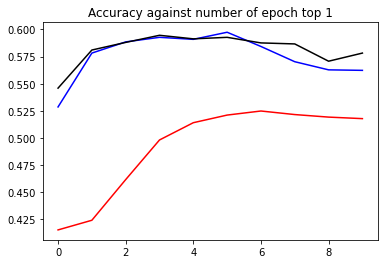

In [12]:
import matplotlib.pyplot as plt

plt.title("Accuracy against number of epoch top 1")
plt.plot([i for i in range(EPOCH_NUM)], mean_accuracies , label='test 1', color='red')
plt.plot([i for i in range(EPOCH_NUM)], topk_accuracies , label='test 1', color='blue')
plt.plot([i for i in range(EPOCH_NUM)], min_accuracies , label='test 1', color='black')


In [13]:
print("maximum of min", round(np.max(min_accuracies), 3))
print("maximum of topk", round(np.max(topk_accuracies), 3))
print("maximum of mean", round(np.max(mean_accuracies), 3))


maximum of min 0.595
maximum of topk 0.597
maximum of mean 0.525


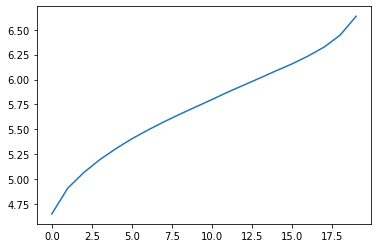

In [14]:
plt.plot(means.cpu())

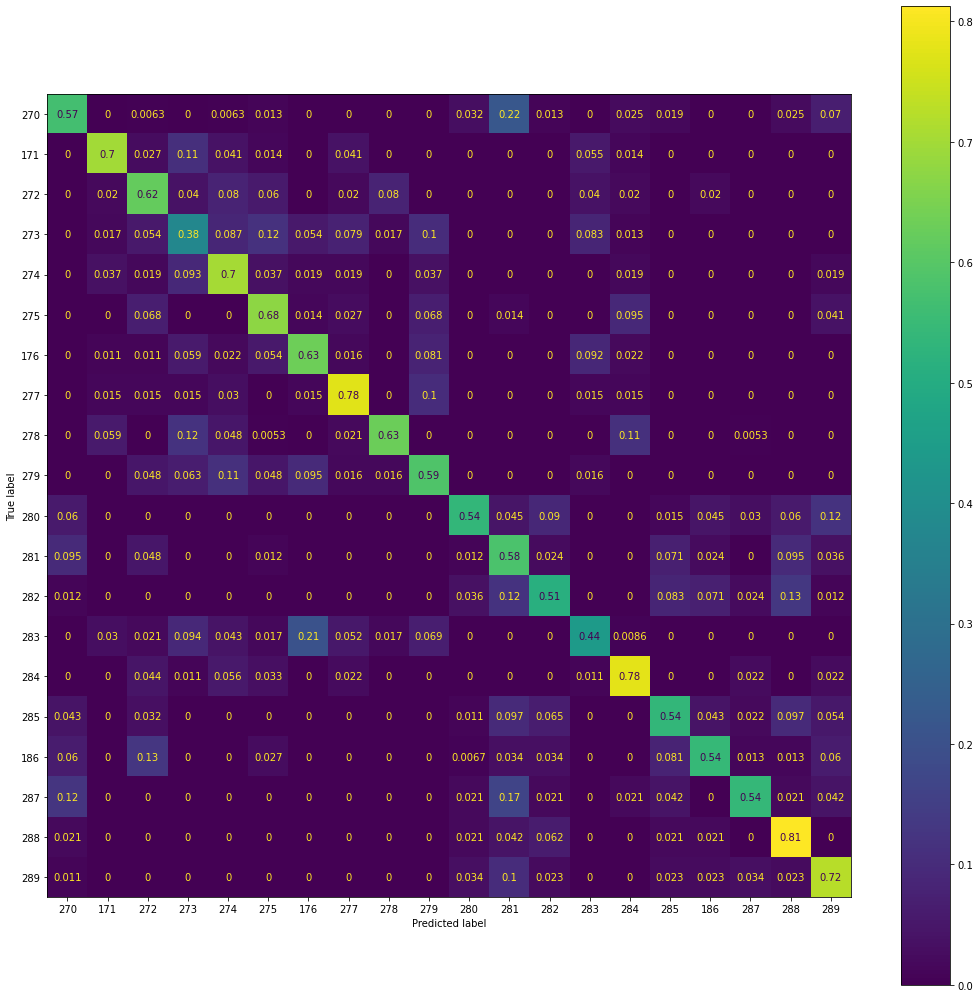

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(conf_gold_label, conf_pred_label, normalize='true')
fig, ax = plt.subplots(figsize=(18, 18))
disp = ConfusionMatrixDisplay(cm, [270, 171, 272, 273, 274, 275, 176, 277, 278, 279, 280, 281, 282, 283, 284, 285, 186, 287, 288, 289]).plot(ax=ax)
plt.show()